<a href="https://www.kaggle.com/code/jakubwalczykowski/compleate-disaster-lstm-gru-cnn-3?scriptVersionId=131572351" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install emot
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.5/125.5 kB 12.2 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import pkg_resources
from symspellpy import SymSpell, Verbosity
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# 1. Data upload and short EDA

In [3]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sub_df = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


<AxesSubplot:>

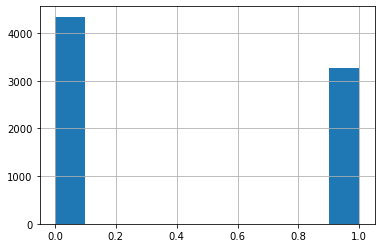

In [4]:
train_df['target'].hist()

In [5]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
def visualize(label):
  words = ''
  for msg in train_df[train_df['target'] == label]['text']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=1000, height=600).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
    

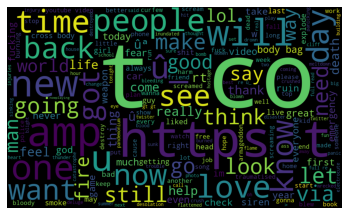

In [9]:
#non-disaster tweets before preprocesing
visualize(0)

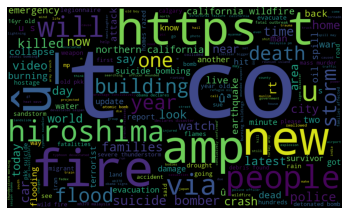

In [10]:
#disaster tweets before preprocesing
visualize(1)

In [11]:
train_df[train_df["target"] == 0]["text"].values[0]

"What's up man?"

In [12]:
train_df[train_df["target"] == 1]["text"].values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [13]:
sub_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0



# 2. Preprocessing

most of preprocessing technic are by Rohit Garud https://www.kaggle.com/code/rohitgarud/all-almost-data-preprocessing-techniques-for-nlp#Final-Stopward-Removal


In [14]:
#converting emojis
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text
train_df["text"] = train_df["text"].apply(convert_emojis)
test_df["text"] = test_df["text"].apply(convert_emojis)

In [15]:
#joining keywords with text      
train_df["keyword"] = train_df["keyword"].fillna("")
train_df["text"] = train_df["keyword"] + " " + train_df["text"]
test_df["keyword"] = test_df["keyword"].fillna("")
test_df["text"] = test_df["keyword"] + " " + test_df["text"]
train_df=train_df.drop(['id','keyword','location'],axis=1)
test_df=test_df.drop(['id','keyword','location'],axis=1)
train_df

,text,target
0,Our Deeds are the Reason of this #earthquake ...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are...,1
3,"13,000 people receive #wildfires evacuation o...",1
4,Just got sent this photo from Ruby #Alaska as...,1
...,...,...
7608,Two giant cranes holding a bridge collapse in...,1
7609,@aria_ahrary @TheTawniest The out of control ...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. ht...,1
7611,Police investigating after an e-bike collided...,1


In [16]:
#removing html code
def remove_html(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    return text
train_df["text"] = train_df["text"].apply(remove_html)
test_df["text"] = test_df["text"].apply(remove_html)
train_df

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [17]:
#converting capital letters
train_df["text"] = train_df["text"].str.lower()
test_df["text"] = test_df["text"].str.lower()
train_df

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @thetawniest the out of control w...,1
7610,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,police investigating after an e-bike collided ...,1


In [18]:
#removing urls
def remove_urls(text):
    pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    text = re.sub(pattern, "", text)
    return text
train_df["text"] = train_df["text"].apply(remove_urls)
test_df["text"] = test_df["text"].apply(remove_urls)
train_df



,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @thetawniest the out of control w...,1
7610,m1.94 [01:04 utc]?5km s of volcano hawaii.,1
7611,police investigating after an e-bike collided ...,1


In [19]:
#removing mentions
def remove_mentions(text):
    pattern = re.compile(r"@\w+")
    text = re.sub(pattern, "", text)
    return text
train_df["text"] = train_df["text"].apply(remove_mentions)
test_df["text"] = test_df["text"].apply(remove_mentions)
train_df

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,the out of control wild fires in california ...,1
7610,m1.94 [01:04 utc]?5km s of volcano hawaii.,1
7611,police investigating after an e-bike collided ...,1


In [20]:
#removing unicode chars
def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text
train_df["text"] = train_df["text"].apply(remove_unicode_chars)
test_df["text"] = test_df["text"].apply(remove_unicode_chars)
train_df

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,the out of control wild fires in california ...,1
7610,m1.94 [01:04 utc]?5km s of volcano hawaii.,1
7611,police investigating after an e-bike collided ...,1


In [21]:
#removing punctuations
string.punctuation
def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text
train_df["text"] = train_df["text"].apply(remove_punctuations)
test_df["text"] = test_df["text"].apply(remove_punctuations)
train_df

,text,target
0,our deeds are the reason of this earthquake m...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are ...,1
3,13 000 people receive wildfires evacuation or...,1
4,just got sent this photo from ruby alaska as ...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,the out of control wild fires in california ...,1
7610,m1 94 01 04 utc 5km s of volcano hawaii,1
7611,police investigating after an e bike collided ...,1


In [22]:
#removing extra spaces
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text
train_df["text"] = train_df["text"].apply(remove_extra_spaces)
test_df["text"] = test_df["text"].apply(remove_extra_spaces)
train_df

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13 000 people receive wildfires evacuation ord...,1
4,just got sent this photo from ruby alaska as s...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,the out of control wild fires in california ev...,1
7610,m1 94 01 04 utc 5km s of volcano hawaii,1
7611,police investigating after an e bike collided ...,1


In [23]:
#correcting spelling with symspell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
def correct_spelling_symspell(text):
    words = [
        sym_spell.lookup(
            word, 
            Verbosity.CLOSEST, 
            max_edit_distance=2,
            include_unknown=True
            )[0].term 
        for word in text.split()] 
    text = " ".join(words)
    return text
train_df["text"] = train_df["text"].apply(correct_spelling_symspell)
test_df["text"] = test_df["text"].apply(correct_spelling_symspell)
train_df

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la range sask canada,1
2,all residents asked to shelter in place are be...,1
3,of 000 people receive wildfires evacuation ord...,1
4,just got sent this photo from ruby alaska as s...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,the out of control wild fires in california ev...,1
7610,my of of of etc pm a of volcano hawaii,1
7611,police investigating after an a bike collided ...,1


In [24]:
#Correcting Componded Words
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
def correct_spelling_symspell_compound(text):
    words = [
        sym_spell.lookup_compound(
            word, 
            max_edit_distance=2
            )[0].term 
        for word in text.split()] 
    text = " ".join(words)
    return text
train_df["text"] = train_df["text"].apply(correct_spelling_symspell_compound)
test_df["text"] = test_df["text"].apply(correct_spelling_symspell_compound)
train_df

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la range sask canada,1
2,all residents asked to shelter in place are be...,1
3,of of a people receive wildfires evacuation or...,1
4,just got sent this photo from ruby alaska as s...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,the out of control wild fires in california ev...,1
7610,my of of of etc pm a of volcano hawaii,1
7611,police investigating after an a bike collided ...,1


In [25]:
#removing stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
train_df["text"] = train_df["text"].apply(remove_stopwords)
test_df["text"] = test_df["text"].apply(remove_stopwords)
train_df

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la range sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...
7608,two giant cranes holding bridge collapse nearb...,1
7609,control wild fires california even northern pa...,1
7610,etc pm volcano hawaii,1
7611,police investigating bike collided car little ...,1


In [26]:
# lemmatizing
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text
train_df["text"] = train_df["text"].apply(lemmatize_text)
test_df["text"] = test_df["text"].apply(lemmatize_text)
train_df

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la range sask canada,1
2,resident asked shelter place notified officer ...,1
3,people receive wildfire evacuation order calif...,1
4,got sent photo ruby alaska smoke wildfire pour...,1
...,...,...
7608,two giant crane holding bridge collapse nearby...,1
7609,control wild fire california even northern par...,1
7610,etc pm volcano hawaii,1
7611,police investigating bike collided car little ...,1


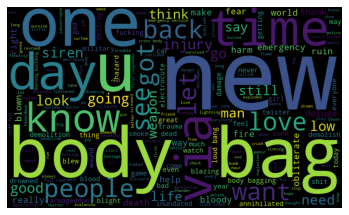

In [27]:
#non-disaster tweets after preprocesing
visualize(0)

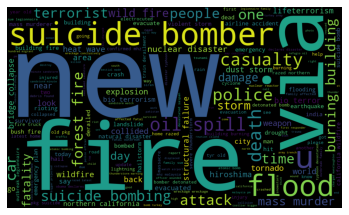

In [28]:
#disaster tweets after preprocesing
visualize(1)

# 3. Embedding, Tokenizing

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
from keras.models import Sequential, load_model

In [30]:
X=train_df['text']
y=train_df['target']
print(X.shape)
print(y.shape)

(7613,)
(7613,)


In [31]:
X

0              deed reason earthquake may allah forgive u
1                   forest fire near la range sask canada
2       resident asked shelter place notified officer ...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    control wild fire california even northern par...
7610                                etc pm volcano hawaii
7611    police investigating bike collided car little ...
7612    latest home razed northern california wildfire...
Name: text, Length: 7613, dtype: object

In [32]:
# Concatenating all words
# Some ideas from https://www.kaggle.com/code/alirezasepidbar/rnn-nlp-competition/notebook    by Alireza Sepidbar
all = np.concatenate((X, test_df['text']))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

T = max(len(x.split()) for x in all)
print(T)

12153
23


In [33]:
# Tokenizing
sequences_train = tokenizer.texts_to_sequences(X)
sequences_test = tokenizer.texts_to_sequences(test_df['text'])

In [34]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 12152 unique tokens.


In [35]:
# pading
X = pad_sequences(sequences_train,maxlen=T)
test_df = pad_sequences(sequences_test,maxlen=T)
print(X.shape)
T = X.shape[1]
X
#, padding='post'

(7613, 23)


array([[   0,    0,    0, ..., 1358, 3306,   20],
       [   0,    0,    0, ..., 2530, 6689,  964],
       [   0,    0,    0, ...,  534,  435, 1089],
       ...,
       [   0,    0,    0, ...,   28,  280, 1431],
       [   0,    0,    0, ...,   41, 1812,   25],
       [   0,    0,    0, ...,   59,  519,    6]], dtype=int32)

In [36]:
# Over Sampling
from imblearn.over_sampling import RandomOverSampler
RandomOverSampler = RandomOverSampler(random_state = 42)
X,y = RandomOverSampler.fit_resample(X,y)
print(X.shape)

(8684, 23)


In [37]:
print(test_df.shape[1])
test_df

23


array([[   0,    0,    0, ..., 1373,   55,   30],
       [   0,    0,    0, ...,  530, 1130,  337],
       [   0,    0,    0, ...,  448, 1255,  358],
       ...,
       [   0,    0,    0, ...,  394,  202,  770],
       [   0,    0,    0, ...,  191,  314, 1628],
       [   0,    0,    0, ...,    3,   61,    9]], dtype=int32)

# 4. LSTM

In [38]:
D = 2
K = 1
i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(8))(x)
x = Dropout(0.5)(x)
x = Dense(K, activation='sigmoid')(x)
model1 = Model(i, x)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 23, 2)             24306     
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                704       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 25,027
Trainable params: 25,027
Non-trainable params: 0
_________________________________________________________________


In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(loss='BinaryCrossentropy', optimizer=optimizer, metrics=['accuracy'])

In [40]:
from keras.callbacks import ModelCheckpoint
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1, min_lr=1e-7)
checkpointer = ModelCheckpoint(filepath="best_weights1.hdf5", monitor = "val_loss",verbose=0, save_best_only=True)

In [41]:
class_weight = {0: 1.,1: 1.1}
print('Training model...')
r1 = model1.fit(X, y, epochs=30, validation_split=0.1, shuffle=True, batch_size=16, class_weight= class_weight, validation_batch_size=16, callbacks=[reduce_lr, checkpointer])

Training model...
Epoch 1/30
489/489 [==============================] - 84s 152ms/step - loss: 0.7234 - accuracy: 0.5391 - val_loss: 0.7063 - val_accuracy: 0.0000e+00
Epoch 2/30
489/489 [==============================] - 79s 161ms/step - loss: 0.7219 - accuracy: 0.5591 - val_loss: 0.7148 - val_accuracy: 0.0000e+00
Epoch 3/30
489/489 [==============================] - 79s 162ms/step - loss: 0.7176 - accuracy: 0.5743 - val_loss: 0.7176 - val_accuracy: 0.0736

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 4/30
489/489 [==============================] - 80s 164ms/step - loss: 0.7098 - accuracy: 0.6250 - val_loss: 0.7089 - val_accuracy: 0.2785
Epoch 5/30
489/489 [==============================] - 79s 162ms/step - loss: 0.7022 - accuracy: 0.6893 - val_loss: 0.6993 - val_accuracy: 0.4212
Epoch 6/30
489/489 [==============================] - 80s 164ms/step - loss: 0.6917 - accuracy: 0.7402 - val_loss: 0.6809 - val_accuracy: 0.5639
Epoch 7/30
489/489 [==

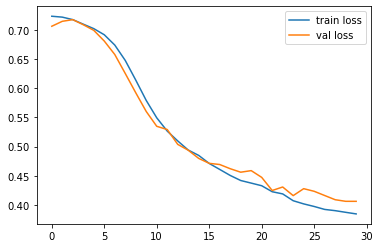

In [42]:
# Plot loss per iteration
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend();

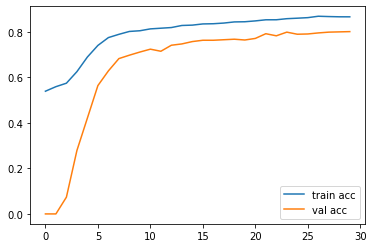

In [43]:
# Plot accuracy per iteration
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend();

In [44]:
print("train_score:",model1.evaluate(X,y))

272/272 [==============================] - 4s 14ms/step - loss: 0.3571 - accuracy: 0.8667
train_score: [0.35711395740509033, 0.8666512966156006]


In [45]:
model1.load_weights('best_weights1.hdf5')


In [46]:
print("train_score:",model1.evaluate(X,y))

272/272 [==============================] - 4s 14ms/step - loss: 0.3571 - accuracy: 0.8667
train_score: [0.35711395740509033, 0.8666512966156006]


In [47]:
predction1 = model1.predict(test_df)

sub_df["target"] = predction1
sub_df.head()

,id,target
0,0,0.541504
1,2,0.648097
2,3,0.756664
3,9,0.593650
4,11,0.723708


# 5. CNN

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [49]:
D = 50
i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Conv1D(16, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(8, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K, activation='sigmoid')(x)

model2 = Model(i, x)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 23, 50)            607650    
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 16)            2416      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 8)              392       
_________________________________________________________________
global_max_pooling1d (Global (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9   

In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(loss='BinaryCrossentropy', optimizer=optimizer, metrics=['accuracy'])

In [51]:
checkpointer = ModelCheckpoint(filepath="best_weights2.hdf5", monitor = "val_loss",verbose=0, save_best_only=True)

In [52]:
class_weight = {0: 1.,1: 1.1}
print('Training model...')
r2 = model2.fit(X, y, epochs=20, validation_split=0.2, shuffle=True, batch_size=16, class_weight= class_weight, validation_batch_size=16, callbacks=[reduce_lr, checkpointer])

Training model...
Epoch 1/20
435/435 [==============================] - 9s 6ms/step - loss: 0.7170 - accuracy: 0.5777 - val_loss: 0.7512 - val_accuracy: 0.1894
Epoch 2/20
435/435 [==============================] - 2s 4ms/step - loss: 0.7091 - accuracy: 0.5777 - val_loss: 0.7553 - val_accuracy: 0.1894
Epoch 3/20
435/435 [==============================] - 2s 5ms/step - loss: 0.6957 - accuracy: 0.5777 - val_loss: 0.7483 - val_accuracy: 0.1906
Epoch 4/20
435/435 [==============================] - 2s 5ms/step - loss: 0.6645 - accuracy: 0.6072 - val_loss: 0.7189 - val_accuracy: 0.3863
Epoch 5/20
435/435 [==============================] - 2s 5ms/step - loss: 0.5944 - accuracy: 0.7779 - val_loss: 0.6666 - val_accuracy: 0.6621
Epoch 6/20
435/435 [==============================] - 2s 5ms/step - loss: 0.4975 - accuracy: 0.8470 - val_loss: 0.5648 - val_accuracy: 0.7818
Epoch 7/20
435/435 [==============================] - 2s 5ms/step - loss: 0.4066 - accuracy: 0.8730 - val_loss: 0.4779 - val_accur

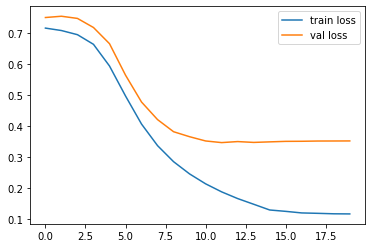

In [53]:
# Plot loss per iteration
plt.plot(r2.history['loss'], label='train loss')
plt.plot(r2.history['val_loss'], label='val loss')
plt.legend();

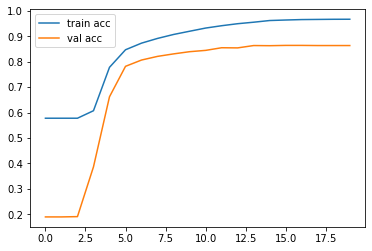

In [54]:
# Plot accuracy per iteration
plt.plot(r2.history['accuracy'], label='train acc')
plt.plot(r2.history['val_accuracy'], label='val acc')
plt.legend();

In [55]:
print("train_score:",model2.evaluate(X,y))

272/272 [==============================] - 1s 2ms/step - loss: 0.1585 - accuracy: 0.9465
train_score: [0.15853005647659302, 0.9464532732963562]


In [56]:
model2.load_weights('best_weights2.hdf5')


In [57]:
print("train_score:",model2.evaluate(X,y))

272/272 [==============================] - 1s 2ms/step - loss: 0.1937 - accuracy: 0.9342
train_score: [0.19365186989307404, 0.9342468976974487]


In [58]:
predction2 = model2.predict(test_df)
sub_df["target"] = predction2
sub_df.head()

,id,target
0,0,0.721427
1,2,0.791038
2,3,0.967504
3,9,0.826312
4,11,0.932767


# 6. GRU

In [59]:
D = 20
K = 1
i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = GRU(16)(x)
x = Dropout(0.5)(x)
x = Dense(8)(x)
x = Dropout(0.3)(x)
x = Dense(K, activation='sigmoid')(x)

model3 = Model(i, x)
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 23, 20)            243060    
_________________________________________________________________
gru (GRU)                    (None, 16)                1824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9   

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model3.compile(loss='BinaryCrossentropy', optimizer=optimizer, metrics=['accuracy'])

In [61]:
class_weight = {0: 1.,1: 1.1}
print('Training model...')
r3 = model3.fit(X, y, epochs=20, validation_split=0.15, shuffle=True, batch_size=16, class_weight= class_weight, validation_batch_size=16, callbacks=[reduce_lr, checkpointer])

Training model...
Epoch 1/20
462/462 [==============================] - 41s 82ms/step - loss: 0.7194 - accuracy: 0.5632 - val_loss: 0.7393 - val_accuracy: 0.0883
Epoch 2/20
462/462 [==============================] - 36s 78ms/step - loss: 0.7130 - accuracy: 0.5753 - val_loss: 0.7495 - val_accuracy: 0.0959
Epoch 3/20
462/462 [==============================] - 36s 78ms/step - loss: 0.6919 - accuracy: 0.6358 - val_loss: 0.6777 - val_accuracy: 0.5480
Epoch 4/20
462/462 [==============================] - 37s 80ms/step - loss: 0.5247 - accuracy: 0.8054 - val_loss: 0.4388 - val_accuracy: 0.7797
Epoch 5/20
462/462 [==============================] - 37s 79ms/step - loss: 0.4060 - accuracy: 0.8493 - val_loss: 0.3869 - val_accuracy: 0.8150
Epoch 6/20
462/462 [==============================] - 36s 79ms/step - loss: 0.3601 - accuracy: 0.8721 - val_loss: 0.3574 - val_accuracy: 0.8250
Epoch 7/20
462/462 [==============================] - 36s 79ms/step - loss: 0.3139 - accuracy: 0.8916 - val_loss: 0.31

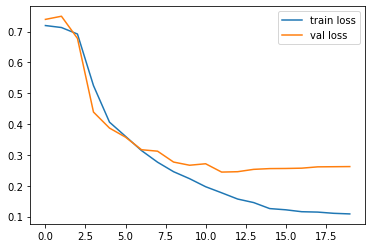

In [62]:
# Plot loss per iteration
plt.plot(r3.history['loss'], label='train loss')
plt.plot(r3.history['val_loss'], label='val loss')
plt.legend();

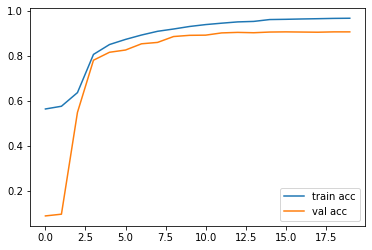

In [63]:
# Plot accuracy per iteration
plt.plot(r3.history['accuracy'], label='train acc')
plt.plot(r3.history['val_accuracy'], label='val acc')
plt.legend();

In [64]:
print("train_score:",model3.evaluate(X,y))

272/272 [==============================] - 2s 6ms/step - loss: 0.1176 - accuracy: 0.9568
train_score: [0.11764983832836151, 0.9568171501159668]


In [65]:
#model3.load_weights('best_weights3.hdf5')


In [66]:
print("train_score:",model3.evaluate(X,y))

272/272 [==============================] - 2s 7ms/step - loss: 0.1176 - accuracy: 0.9568
train_score: [0.11764983832836151, 0.9568171501159668]


In [67]:
predction3 = model3.predict(test_df)

sub_df["target"] = predction3
sub_df.head()


,id,target
0,0,0.643839
1,2,0.142910
2,3,0.999984
3,9,0.921641
4,11,0.998114


# 7. Mean prediction for submission

In [68]:
pred= (predction1 + predction2 + predction3)/3
sub_df["target"] = pred
sub_df.head()

,id,target
0,0,0.635590
1,2,0.527348
2,3,0.908051
3,9,0.780535
4,11,0.884863


In [69]:
sub_df["target"] =sub_df["target"].apply(lambda x : 0 if x<=.5 else 1)
sub_df.to_csv("submission.csv", index=False)



Thank you, feedback is highly appreciated! :)

Please upvote if you found this helpful 👍
